In [43]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
import nltk
from collections import Counter 
import re
from nltk.corpus import stopwords
stop_words  = set(stopwords.words('english'))
stop_words.update([".","!",',','?','@','..',','])
import emoji
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from gensim.summarization import keywords
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
ds = r"\b(?:a*(?:ha)+h?|(?:l+o+)+`l+)\b"    ## detect haha and lol word.
emotion_list = [ ':)', ':-)', ':(',':D',':-D',':P',':-P','<3','<-3',\
                ':v','(y)',':poop',':(',':-(']

In [44]:
len(emotion_list)

14

In [45]:
# take list of string.
def getFeatureVectorName():
    temp = []
#     for item in emoji_list:
#         temp.append(item)
    temp.append("haha")
    temp.append("lol")
#     for item in emotion_list:
#         temp.append(item)
    return temp

def generateFeatureVector(s):
    input_string = " ".join(s)
#     res = Counter(" ".join(input_string))
#     res = Counter(s)
    f_v=[]
#     for item in emoji_list:
#         f_v.append(res[item])
    
    count_haha = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape("haha"), input_string))
    count_lol = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape("lol"), input_string))
    
    f_v.append(count_haha)
    f_v.append(count_lol)

    
#     for item in emotion_list:
#         f_v.append(input_string.count(item))
        
    
    
    return f_v
    

In [46]:
import sqlite3
conn = sqlite3.connect('youtube')
cursor = conn.cursor()

In [47]:
def load_data(file):
    cnt=0
    x1=[]
    x2=[]
    y_train=[]
    with open(file, "r") as fd:
        lines = fd.read().splitlines()
    for line in lines:
        word = line.split(',')
        y_train.append(word[2])
        x1.append(word[0])
        x2.append(word[1])
        
    temp = []
    for i in range(0,len(x1)):
        rows1 = conn.execute("select movieid , comment from youtube_info where movieid in (?)",(x1[i],))
        rows2 = conn.execute("select movieid , comment from youtube_info where movieid in (?)",(x2[i],))
        l1 = len(rows1.fetchall())
        l2 = len(rows2.fetchall())
        rows1 = conn.execute("select movieid , comment from youtube_info where movieid in (?)",(x1[i],))
        rows2 = conn.execute("select movieid , comment from youtube_info where movieid in (?)",(x2[i],))
        if(l1 and l2):
            for row in rows1:
                m1=row[0]
                c1=row[1]
            for row in rows2:
                m2=row[0]
                c2=row[1]
            temp.append([m1,m2,c1,c2,c1+c2,y_train[i]])
    df = pd.DataFrame(temp,columns=['m1','m2','c1','c2','all','class'])
    df = df[(df[df.columns] != "NULL").all(axis=1)]
    return df

    

In [48]:
file_train ="comedy_comparisons/comedy_comparisons.train"
file_test = "comedy_comparisons/comedy_comparisons.test"
df_train = load_data(file_train)
# df_test  = load_data(file_test)
# df_test = df_test.head(10)
# df_train = df_train.head(10)


# x1,x2,comment_x1,comment_x2= load_data(file)

In [49]:
# print(df_test.shape)
# print(df_train.shape)


In [50]:
def processComment(comment):
    import re
    ds = r"\b(?:a*(?:ha)+h?|(?:l+o+)+`l+)\b"    ## detect haha and lol word.
    ps = PorterStemmer() 
    corpus = []
    for line in comment:
        line = line.lower();
        words = word_tokenize(line)
        temp = []
        for w in words:
#             if w not in stop_words:
            pattern_word = re.findall(ds,w)
            if len(pattern_word):
                if(pattern_word[0].find("haha")!=-1):
                    w = "haha"
                if(pattern_word[0].find("lol")!=-1):
                    w="lol"
            temp.append(ps.stem(w.lower()))
        corpus.append(temp)
    return corpus

def changeDataFrame(df):
    comment1 = processComment(df['c1'])
    comment2 = processComment(df['c2'])
    c=[]
    for item in df['class']:
        if item=="left":
            c.append(0)
        elif item == "right":
            c.append(1)
    df['class']=c
    df['c1'] = comment1
    df['c2']=comment2
    c1_feature=[]
    c2_feature=[]
    
    for item in df['c1']:
        c1_feature.append(generateFeatureVector(item))
    for item in df['c2']:
        c2_feature.append(generateFeatureVector(item))
        
    c1_subtract=[]
    for i in range(0,len(c1_feature)):
        temp=[]
        for j in range(0,len(c1_feature[i])):
            temp.append(c1_feature[i][j]-c2_feature[i][j])
        c1_subtract.append(temp)
            
    new_df = pd.DataFrame(c1_subtract)
    new_df.columns = getFeatureVectorName()
    temp = []
    
    for item in new_df.columns:
        col_name = "is_"+item
        l=list(new_df[item]>0)
        
        for i in range(0,len(l)):
            if l[i] == True:
                l[i]=1
            else:
                l[i]=0
        new_df[col_name]=l
        
    new_df['class']=c
    return new_df
    
    




##takes input as a dataframe
def getListOfAllEmoji(df):
    emoji_list=[]
    for item in df['c1']:
        for c in item:
            if c in emoji.UNICODE_EMOJI:
                emoji_list.append(c)
    for item in df['c2']:
        for c in item:
            if c in emoji.UNICODE_EMOJI:
                emoji_list.append(c)
    emoji_list = set(emoji_list) 
    emoji_list = list(emoji_list)
    return emoji_list

# emoji_list = getListOfAllEmoji(df_train)


In [51]:
print(df_train.shape)

(223328, 6)


In [52]:
df_train = df_train.head(50000)

In [53]:
# df_train = df_train.head(10)
df_train = changeDataFrame(df_train)

In [16]:
# df_train.to_csv("df_train")

In [3]:
df_train = pd.read_csv("df_train")
del df_train['Unnamed: 0']

In [18]:
print(df_train.shape)
df_train.columns

(223328, 5)


Index(['haha', 'lol', 'is_haha', 'is_lol', 'class'], dtype='object')

In [54]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
# representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.subplot(1, 3, 3)
# representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

In [55]:
df_train.head()

,haha,lol,is_haha,is_lol,class
0,2,2,1,1,0
1,2,1,1,1,0
2,2,2,1,1,0
3,-1,-4,0,0,1
4,20,25,1,1,0


# LOGISTIC REGRESSION

In [56]:
y = df_train['class']
# del df_train['class']
X= df_train

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=1000,n_jobs=-1).fit(X_train, y_train)

In [58]:
print(X_train.shape)
print(X_test.shape)

(33500, 5)
(16500, 5)


In [59]:
y_pred = clf.predict(X_test)

In [60]:
accuracy_score(y_test,y_pred)

1.0

In [61]:
from sklearn.metrics import accuracy_score

# Confusion matrix.

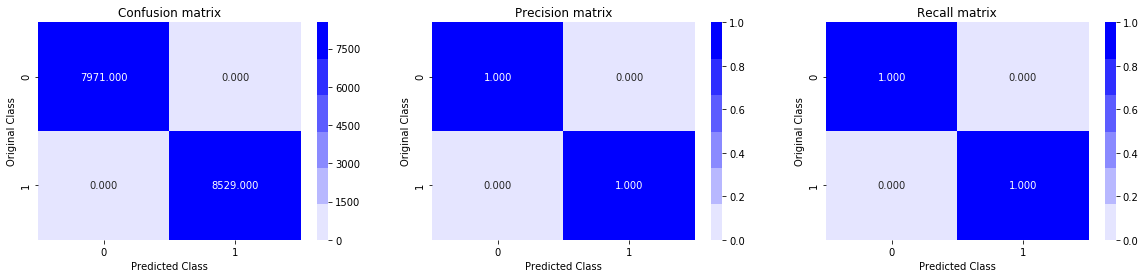

In [62]:
plot_confusion_matrix(y_test,y_pred)

# STEPS:-

1) Collected maximum 20 comment from each youtube id. <br>

2) Discard those dataset which youtube id exist but youtube video itself doesn't exist itself. <br>

3) Manully handcraft "haha" and "lol" feature for which i got 100 percent accuracy. I tried all the emoji, but "haha" and "lol" feature gives me  very pretty performance. <br> 

4)Total feature =["haha","lol","is_haha","is_lol"] <br> where "is_haha" represent boolean expression(count("haha") on left_id > count("haha") on right_id" and same for "lol" feature. <br>
  
5) Applied Logistic Regression model with total of two feature named as "haha" and "lol" and it gives me 100 percent accuracy. <br>



# Conclusion

In [63]:
from prettytable import PrettyTable

In [64]:
x = PrettyTable()
x.field_names = ["model_name","training Accuracy","test_Accuracy"]

In [ ]:
x.add_row(["Logistic Regression",accuracy_score(y_train,clf.predict(X_train)),accuracy_score(y_test,clf.predict(X_test))])

In [ ]:
print(x)